In [59]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [60]:
import numpy as np 
import tensorflow as tf 
import random 
import os 
import string 
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [61]:
seed=42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [62]:
train_data=pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv")
test_data=pd.read_csv("/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv")
print("train_data Shape: ",train_data.shape,"test_data Shape: ",test_data.shape)

train_data Shape:  (27455, 785) test_data Shape:  (7172, 785)


In [65]:
strlabels=list(string.ascii_uppercase) 
strlabels.remove("J")
print(strlabels) 

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [66]:
train_labels=train_data["label"]
train_images=train_data.drop("label",axis=1).values
test_labels=test_data["label"]
test_images=test_data.drop("label",axis=1).values 
                                               
train_images=train_images/255.0 
test_images=test_images/255.0

train_images=train_images.reshape(-1,28,28,1) 
test_images=test_images.reshape(-1,28,28,1)
print(train_images.shape)

(27455, 28, 28, 1)


[Text(0, 0.5, 'Test Images'), Text(0.5, 0, 'Test Labels')]

<Figure size 1500x500 with 0 Axes>

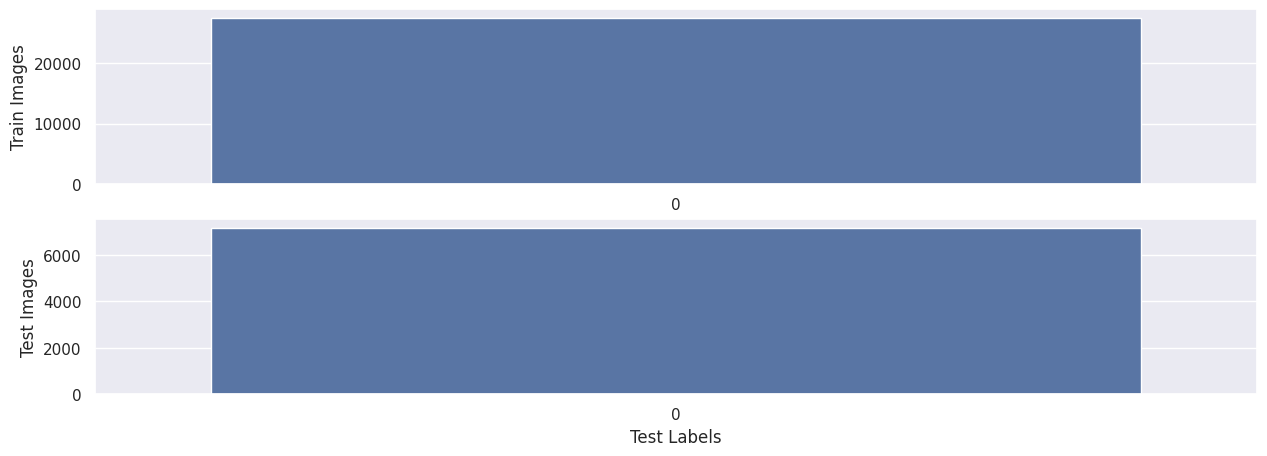

In [68]:
plt.figure() 
plt.tight_layout() 
fig,ax=plt.subplots(2,1) 
sns.set(rc={'figure.figsize':(15,15)})
sns.countplot(train_labels,ax=ax[0])
ax[0].set(ylabel="Train Images", xlabel = "Train Labels")
sns.countplot(test_labels,ax=ax[1])
ax[1].set(ylabel="Test Images", xlabel = "Test Labels") 

<Figure size 1500x1500 with 0 Axes>

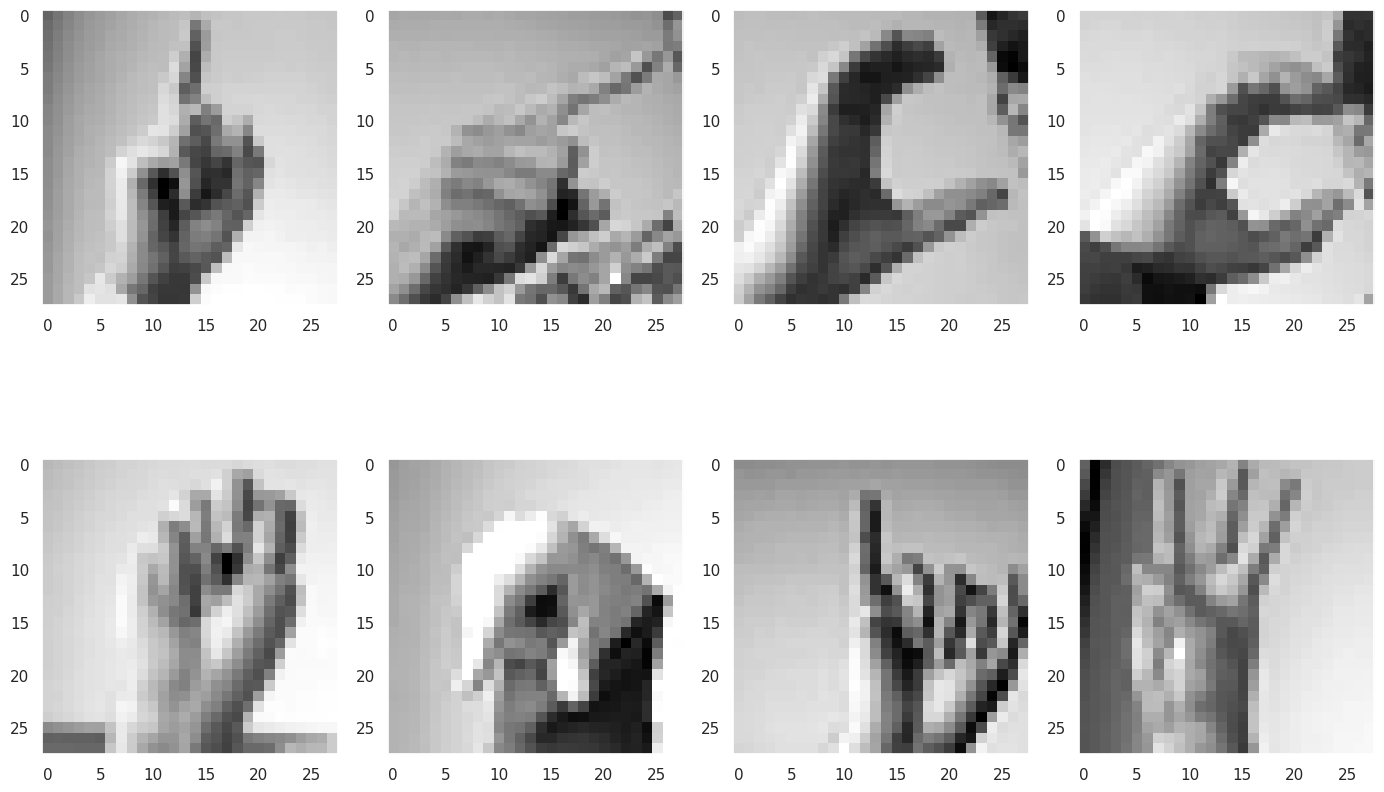

In [74]:
plt.figure() 
f, graph = plt.subplots(2,4) 
f.set_size_inches(14, 10) 
z=0
for i in range(2):
    for k in range(4): 
        graph[i][k].imshow(train_images[z].reshape(28,28),cmap="gray") 
        graph[i][k].grid(False)
        z+=1
plt.tight_layout()
plt.show()

In [75]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,
        rotation_range=10, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False,  
        vertical_flip=False)  
generator.fit(train_images)

In [76]:
acc_treshold = 1.0
class myCallback(tf.keras.callbacks.Callback):
    epc=0
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') >= acc_treshold-0.0100 and logs.get('val_acc') >= acc_treshold):
            print("\nReached %2.2f%% accuracy !" %(logs.get('val_acc')*100))
            self.model.stop_training = True
            self.epc=epoch+1
callbacks = myCallback()

In [77]:
model=tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(64,(3,3),padding="same",activation="relu",input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(32,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2),strides=2),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(16,(3,3),padding="same",activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25,activation="softmax")
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),loss="sparse_categorical_crossentropy",metrics=["acc"])
model.summary()
epochs=80
history=model.fit(generator.flow(train_images,train_labels,batch_size=128),epochs=epochs,callbacks=[callbacks],validation_data=(test_images,test_labels),verbose=1)
# for data augmentation.
test_loss,test_acc=model.evaluate(test_images,test_labels)
print("test acc:",test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)      

2023-09-23 12:22:46.411830: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


215/215 [==============================] - 17s 63ms/step - loss: 2.5385 - acc: 0.2499 - val_loss: 3.3173 - val_acc: 0.0420
Epoch 2/80
215/215 [==============================] - 10s 47ms/step - loss: 1.4006 - acc: 0.5478 - val_loss: 2.5129 - val_acc: 0.2036
Epoch 3/80
215/215 [==============================] - 11s 53ms/step - loss: 0.9173 - acc: 0.6947 - val_loss: 0.7582 - val_acc: 0.7659
Epoch 4/80
215/215 [==============================] - 10s 47ms/step - loss: 0.6871 - acc: 0.7674 - val_loss: 1.1140 - val_acc: 0.6050
Epoch 5/80
215/215 [==============================] - 10s 46ms/step - loss: 0.5379 - acc: 0.8195 - val_loss: 0.3564 - val_acc: 0.8820
Epoch 6/80
215/215 [==============================] - 11s 51ms/step - loss: 0.4328 - acc: 0.8542 - val_loss: 0.2563 - val_acc: 0.9129
Epoch 7/80
215/215 [==============================] - 10s 48ms/step - loss: 0.3652 - acc: 0.8781 - val_loss: 0.3315 - val_acc: 0.8848
Epoch 8/80
215/215 [==============================] - 12s 54ms/step - los

In [78]:
prediction=model.predict(test_images)

225/225 [==============================] - 1s 2ms/step


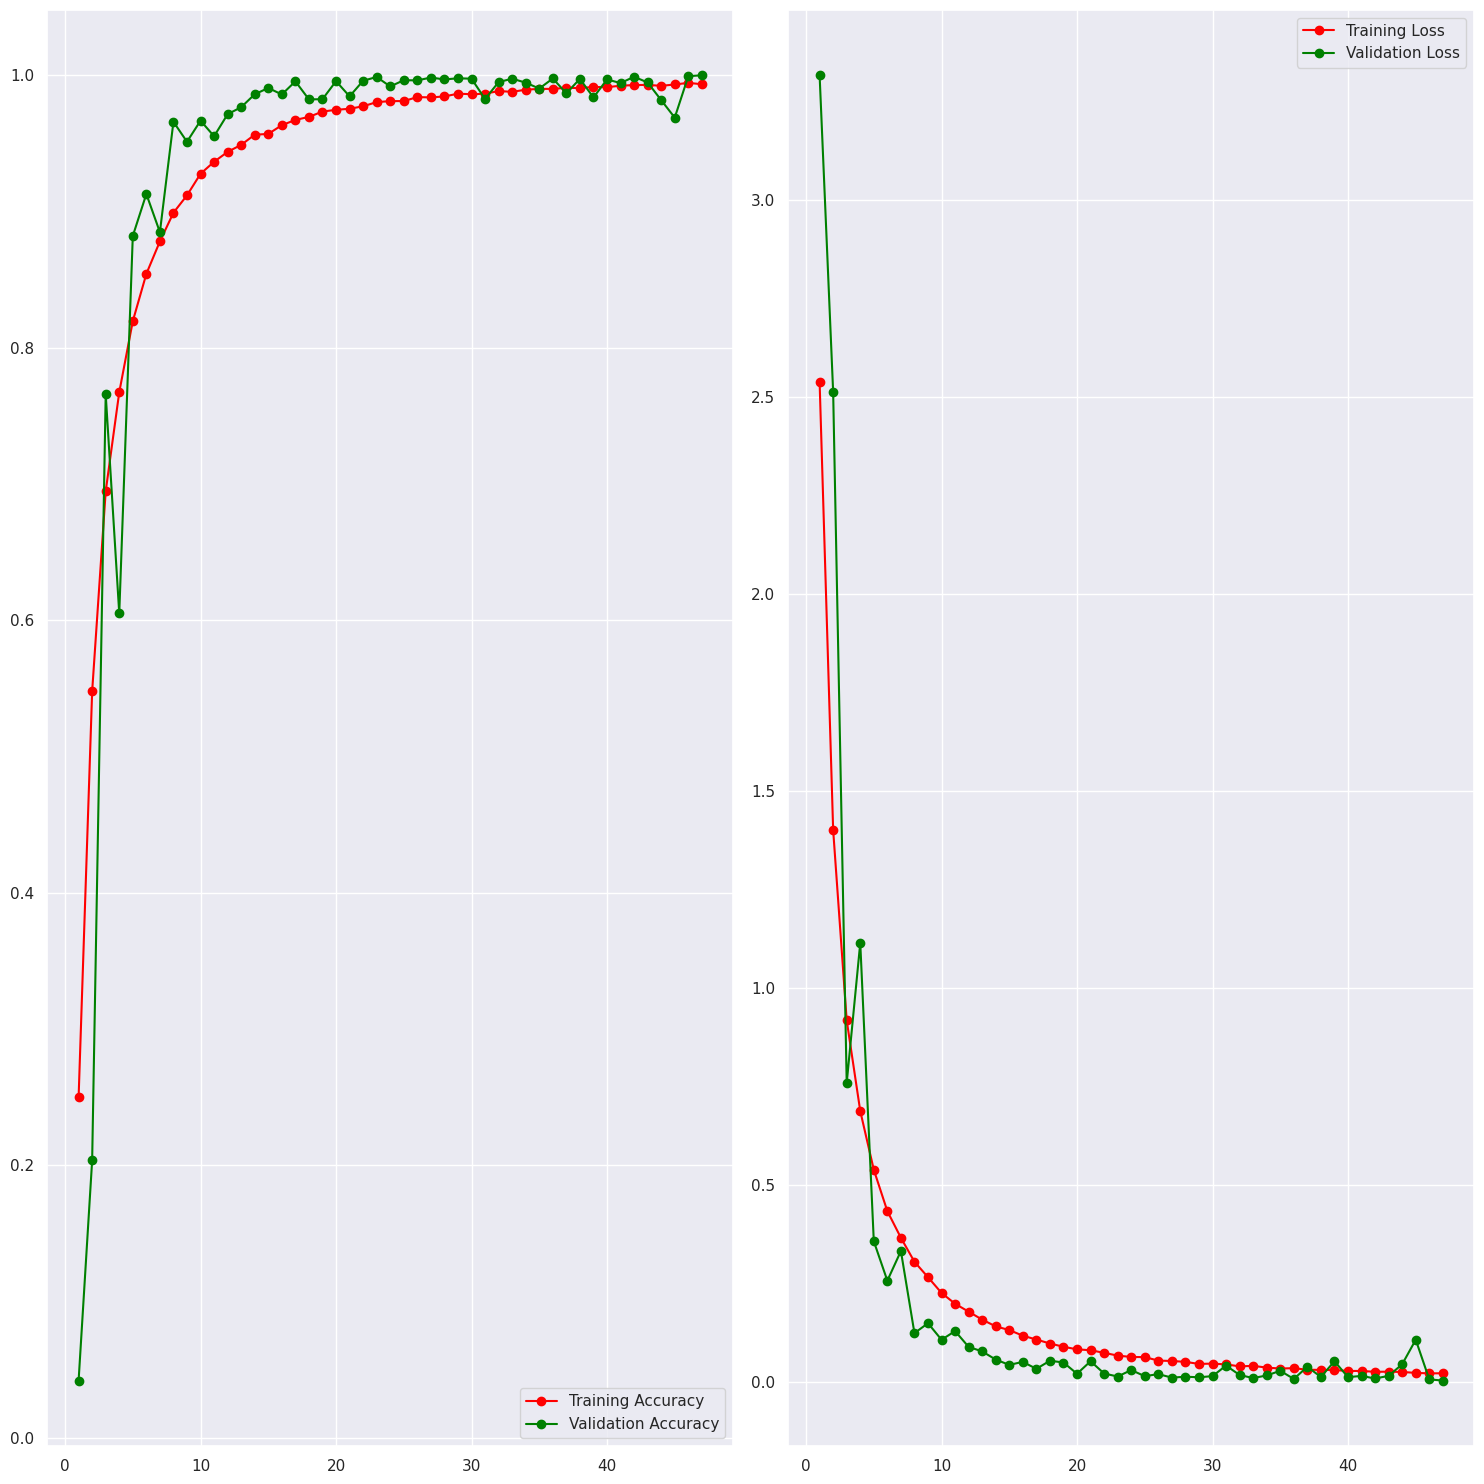

In [113]:
import matplotlib.pyplot as plt

epoch_range = range(1, callbacks.epc + 1 if callbacks.epc != 0 else epochs)
fig.set_size_inches(3,3)

# Create subplots
#plt.figure(figsize=(4, 4)) 
f, ax = plt.subplots(1, 2)

ax[0].plot(epoch_range, history.history["acc"], color="red", marker="o")
ax[0].plot(epoch_range, history.history["val_acc"], color="green", marker="o")
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

ax[1].plot(epoch_range, np.array(history.history["loss"]), color="red", marker="o")
ax[1].plot(epoch_range, np.array(history.history["val_loss"]), color="green", marker="o")
ax[1].legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.tight_layout() 
plt.show()


In [103]:
predictions=[]
test_labels_string=[]
for i in range(0,test_labels.size):
    predictions.append(strlabels[np.argmax(prediction[i])]) 
    test_labels_string.append(strlabels[test_labels[i]])

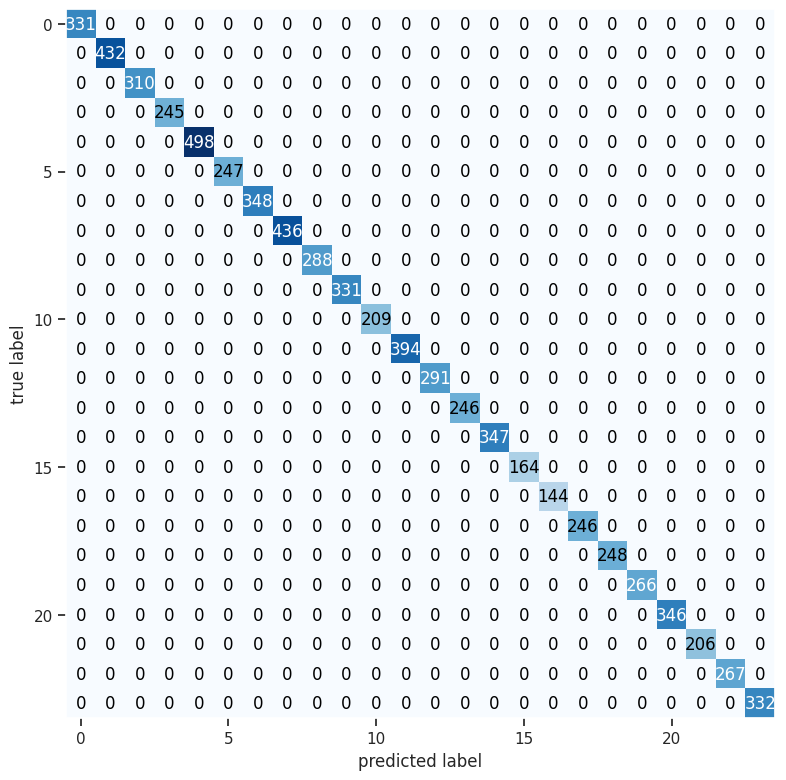

In [104]:
from sklearn.metrics import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix 
cf=confusion_matrix(predictions,test_labels_string)
fig, ax = plot_confusion_matrix(conf_mat=cf)
fig.set_size_inches(8,8) 
plt.tight_layout() 
plt.show()

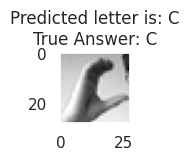

In [136]:
n = 20
plt.figure(figsize=(0.9, 2))  
plt.subplot(1, 1, 1) 
plt.imshow(test_images[n].reshape(28, 28), cmap="gray")
plt.grid(False)
plt.title(f"Predicted letter is: {predictions[n]}\nTrue Answer: {test_labels_string[n]}")

plt.show()

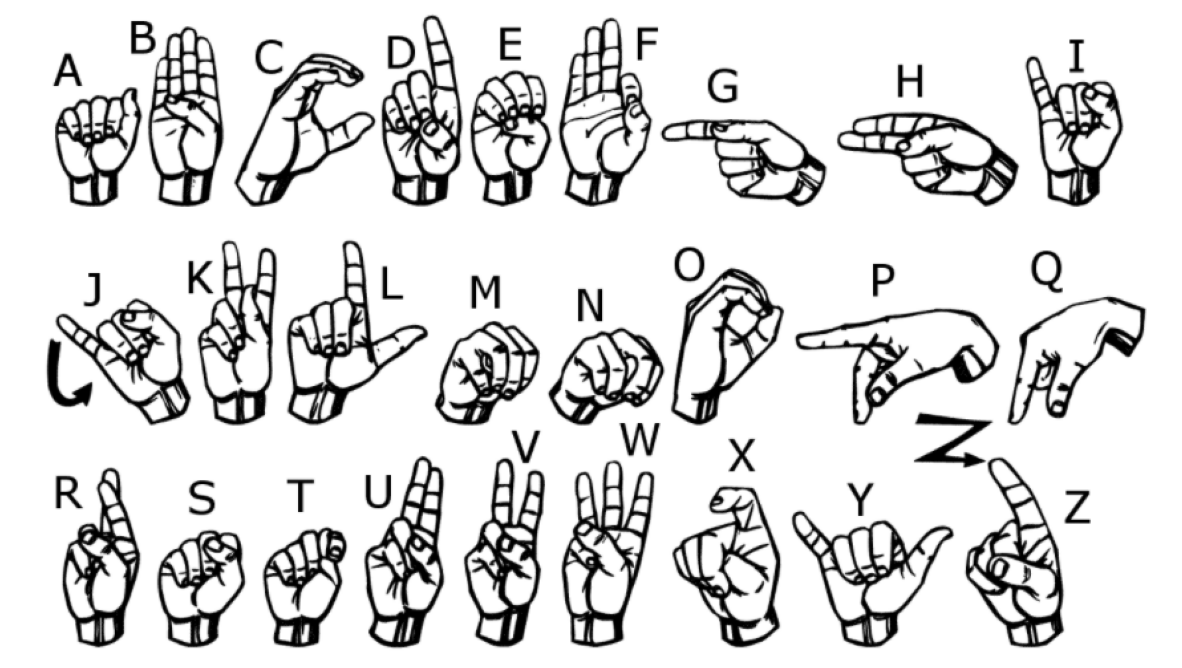

In [115]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/kaggle/input/sign-language-mnist/american_sign_language.PNG'

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  
plt.show()